# MNIST model using Bernoulli 
Note : Used code from 
Fits Bernoulli mixture model for mnist digits using em algorithm
Author: Meduri Venkata Shivaditya, Aleyna Kara(@karalleyna)

In [2]:
from jax.random import PRNGKey, randint, uniform, permutation, split
import jax.numpy as jnp
import jax.dlpack
from jax.lax import scan
from jax import vmap, jit, value_and_grad
from jax.nn import softmax
from jax.scipy.special import expit, logit
from jax.example_libraries import optimizers

import os
import matplotlib.pyplot as plt
import numpy as np
import struct
import tensorflow as tf
import tensorflow_probability as tfp
import distrax
from distrax._src.utils import jittable

import itertools

tfd = tfp.distributions

# Read MNIST dataset

In [3]:
MNIST_HOME_DIR = os.path.join('..','data','mnist')
filenames = {'train' : { 'images' : 'train-images-idx3-ubyte', 'labels' : 'train-labels-idx1-ubyte'}, 
             'test' : { 'images' : 't10k-images-idx3-ubyte', 'labels' : 't10k-labels-idx1-ubyte'} }

def load_data_per_type(data_type='train'):
    with open(os.path.join(MNIST_HOME_DIR, filenames[data_type]['images'], filenames[data_type]['images']), 'rb') as f:
        sign, i_size, row_pixel, col_pixel = struct.unpack(">IIII", f.read(16))
        # print(magic,i_size,rows,cols)
        if sign != 2051 :
            print(f'Signature did not match code : exopected 2051 found : {sign}')
            return
        image_in_bytes = f.read(i_size*row_pixel*col_pixel)
        images = np.frombuffer(image_in_bytes, dtype=np.uint8).astype(np.float32)

    with open(os.path.join(MNIST_HOME_DIR, filenames[data_type]['labels'], filenames[data_type]['labels']), 'rb') as f:
        sign, l_size = struct.unpack(">II", f.read(8))
        # print(magic, size)
        if sign != 2049 :
            print(f'Signature did not match code : exopected 2051 found : {sign}')
            return
        labels_in_bytes = f.read(l_size)
        labels = np.frombuffer(labels_in_bytes, dtype=np.uint8).astype(np.float32)
    return images.reshape(i_size,row_pixel,col_pixel,1),labels

def load_data():
    return load_data_per_type('train'), load_data_per_type('test')

def load_random_data(n_obs):
    images,labels = load_data_per_type('train')
    indexs = np.random.randint(0,images.shape[0],n_obs)
    return images[indexs],labels[indexs]
    

In [4]:
class MixtureSameFamily(distrax.MixtureSameFamily):

    def _per_mixture_component_log_prob(self, value):
        # print(value.shape)
        # print(self.event_shape)
        # print(len(self.event_shape))
        # Add component axis to make input broadcast with components distribution.
        expanded = jnp.expand_dims(value, axis=-1 - len(self.event_shape))
        # print(expanded.shape)
        # Compute `log_prob` in every component.
        lp = self.components_distribution.log_prob(expanded)
        # print(lp.shape)
        # Last batch axis is number of components, i.e. last axis of `lp` below.
        # Last axis of mixture log probs are components.
        return lp + self._mixture_log_probs

    def log_prob(self, value):
        # Reduce last axis of mixture log probs are components
        # print('log_prob : jax.scipy.special.logsumexp(self._per_mixture_component_log_prob(value), axis=-1)')
        return jax.scipy.special.logsumexp(self._per_mixture_component_log_prob(value), axis=-1)

    def posterior_marginal(self, observations):
        # print('posterior_marginal : distrax.Categorical(logits=self._per_mixture_component_log_prob(observations))')
        return distrax.Categorical(logits=self._per_mixture_component_log_prob(observations))

    def posterior_mode(self, observations):
        return jnp.argmax(self._per_mixture_component_log_prob(observations), axis=-1)

# EM Algorithm

In [5]:
class BMM:

    def __init__(self,K,dimension):
        # Intialize the model
        
        rng_key = PRNGKey(0)
        cofficients_per_category = uniform(rng_key, (K,), minval=100, maxval=200)
        cofficients_per_category = cofficients_per_category / cofficients_per_category.sum()

        bernoulli_probs = jnp.full((K, dimension), 1.0/K)
        # print(cofficients_per_category.shape)
        # print(bernoulli_probs.shape)
        for (coeff, mean) in zip(cofficients_per_category, bernoulli_probs):
            print(f'Initial...coefficients : {coeff}, mean : {mean}')
        self._parameters = (cofficients_per_category, bernoulli_probs) 
        self._model = None
        self._store_history = []
       
    def model(self, value):
        cofficients_per_category,bernoulli_probs = value
        self._model = MixtureSameFamily(
            mixture_distribution=distrax.Categorical(probs=cofficients_per_category),
            components_distribution=distrax.Independent(distrax.Bernoulli(probs=bernoulli_probs)),
        )

    def expected_log_likelihood(self,observations):
        return jnp.sum(jnp.nan_to_num(self._model.log_prob(observations)))

    def cofficients_per_category_contribution(self,observations):
        return jnp.nan_to_num(self._model.posterior_marginal(observations).probs)

    def maximization_step(self,observations):
        n_observations, _ = observations.shape

        def m_step_per_bernoulli(bernoulli_probs):
            normalization_const = bernoulli_probs.sum()
            mu = jnp.sum(bernoulli_probs[:, None] * observations, axis=0) / normalization_const
            return mu, normalization_const
        
        mus,norm_consts = vmap(m_step_per_bernoulli, in_axes=(1))(self.cofficients_per_category_contribution(observations))

        return norm_consts/n_observations, mus

    def fit_expectation_maximum(self, observations, num_of_iters = 1):
        iterations = jnp.arange(num_of_iters)
        def train_step(params,iteration_number):
            self.model(params)
            
            log_likelihood = self.expected_log_likelihood(observations)
            cofficients_per_category_contribution = self.cofficients_per_category_contribution(observations)
            self._store_history.append(cofficients_per_category_contribution)
            (cofficients_per_category, bernoulli_probs) = self.maximization_step(observations)
            return (cofficients_per_category, bernoulli_probs), (log_likelihood, cofficients_per_category_contribution)
            # return params, iteration_number
        # scan(train_step, self.parameters, iterations)
        final_parameters, history = scan(train_step, self._parameters, iterations)
        self.model(final_parameters)
        cof_per_category, probs = final_parameters
        self._probs = probs
        self._cofficients_per_category = cof_per_category
        
        # print(final_parameters)
        # self.parameters = final_parameters
        # TODO insert last set of observation values
        ll_hist, responsibility_hist = history

        ll_hist = jnp.append(ll_hist, self.expected_log_likelihood(observations))
        cofficients_per_category_contribution_hist = jnp.vstack(
            [responsibility_hist, jnp.array([self.cofficients_per_category_contribution(observations)])]
        )

        return ll_hist,cofficients_per_category_contribution_hist
    
    def printValues(self):
        for (coeff, mean) in zip(self._cofficients_per_category, self._probs):
            print(f'coefficients : {coeff}, mean : {mean}')
        print(f'Sum of coeff : {sum(self._cofficients_per_category)}')
        
    
    def plot(self, n_row, n_col, file_name):
            if n_row * n_col != len(self._cofficients_per_category):
                raise TypeError(
                    "The number of rows and columns does not match with the number of component distribution."
                )
            fig, axes = plt.subplots(n_row, n_col)

            for (coeff, mean), ax in zip(
                zip(self._cofficients_per_category, self._probs), axes.flatten()
            ):
                mean = mean.reshape(28, 28)
                ax.imshow(mean.reshape(28, 28), cmap=plt.cm.gray)
                ax.set_title("%1.2f" % coeff)
                ax.axis("off")

            fig.tight_layout(pad=1.0)
            # pml.savefig(f"{file_name}.pdf")
            plt.show()

# Stochastic Gradient Descent

In [6]:
opt_init, opt_update, get_params = optimizers.adam(1e-1)

class SGD(jittable.Jittable):

    def __init__(self,K,dimension):
        # Intialize the model
        rng_key = PRNGKey(0)
        cofficients_per_category = uniform(rng_key, (K,), minval=100, maxval=200)
        cofficients_per_category = cofficients_per_category / cofficients_per_category.sum()
        
        bernoulli_probs = jnp.full((K, dimension), 1.0/K)
        for (coeff, mean) in zip(cofficients_per_category, bernoulli_probs):
            print(f'Initial...coefficients : {coeff}, mean : {mean}')
        self._probs = bernoulli_probs
        self.model = (cofficients_per_category, bernoulli_probs) 
    
    @property
    def cofficients_per_category(self):
        return self._model.mixture_distribution.probs
    
    @property
    def probs(self):
        return self._probs
    
    @property
    def model(self):
        return self._model
    
    @model.setter
    def model(self, value):
        # print('...Setting...model...')
        cofficients_per_category,bernoulli_probs = value
        self._model = MixtureSameFamily(
            mixture_distribution=distrax.Categorical(probs=cofficients_per_category),
            components_distribution=distrax.Independent(distrax.Bernoulli(probs=bernoulli_probs)),
        )
        

    def expected_log_likelihood(self,observations):
        return jnp.sum(jnp.nan_to_num(self._model.log_prob(observations)))

    def cofficients_per_category_contribution(self,observations):
        return jnp.nan_to_num(self._model.posterior_marginal(observations).probs)

    def _make_minibatches(self, observations, batch_size, rng_key):
        
        num_train = len(observations)
        perm = permutation(rng_key, num_train)

        def create_mini_batch(batch_idx):
            return observations[batch_idx]
        num_batches = num_train // batch_size
        batch_indices = perm.reshape((num_batches, -1))
        minibatches = vmap(create_mini_batch)(batch_indices)

        return minibatches

    @jit
    def loss_fn(self, params, batch):
        
        cofficients_per_category, probs = params
        self.model = (softmax(cofficients_per_category), expit(probs))
        return -self.expected_log_likelihood(batch) / len(batch)

    @jit
    def update(self, i, opt_state, batch):
        # print(opt_state)
        params = get_params(opt_state)
        # print(params)
        loss, grads = value_and_grad(self.loss_fn)(params, batch)
        return opt_update(i, grads, opt_state), loss
        # return opt_update(i, None, opt_state), None

    def fit_sgd(
        self, observations, batch_size, rng_key=None, optimizer=None, num_epochs=1
    ):
        global opt_init, opt_update, get_params

        if rng_key is None:
            rng_key = PRNGKey(0)

        if optimizer is not None:
            opt_init, opt_update, get_params = optimizer
        # print(self.cofficients_per_category)
        # print('Before...',softmax(self.cofficients_per_category), self.probs)
        opt_state = opt_init((softmax(self.cofficients_per_category), logit(self.probs)))
        itercount = itertools.count()
        def epoch_step(opt_state, key):
            def train_step(opt_state, batch):
                opt_state, loss = self.update(next(itercount), opt_state, batch)
                return opt_state, loss

            batches = self._make_minibatches(observations, batch_size, key)
            opt_state, losses = scan(train_step, opt_state, batches)

            params = get_params(opt_state)
            cofficients_per_category, probs_logits = params
            probs = expit(probs_logits)
            self.model = (softmax(cofficients_per_category), probs)
            self._probs = probs

            return opt_state, (
                losses.mean(),
                *params,
                self.cofficients_per_category_contribution(observations),
            )
        epochs = split(rng_key, num_epochs)
        opt_state, history = scan(epoch_step, opt_state, epochs)
        params = get_params(opt_state)
        # print('After...',params)
        cofficients_per_category, probs_logits = params
        return history, softmax(cofficients_per_category), expit(probs_logits)
        # return []
    
    def plot(self, cofficients_per_category, probs_logits, n_row, n_col, file_name):
            if n_row * n_col != len(cofficients_per_category):
                raise TypeError(
                    "The number of rows and columns does not match with the number of component distribution."
                )
            fig, axes = plt.subplots(n_row, n_col)

            for (coeff, mean), ax in zip(
                zip(cofficients_per_category, probs_logits), axes.flatten()
            ):
                # print(mean)
                ax.imshow(mean.reshape(28, 28), cmap=plt.cm.gray)
                ax.set_title("%1.2f" % coeff)
                ax.axis("off")

            fig.tight_layout(pad=1.0)
            # pml.savefig(f"{file_name}.pdf")
            plt.show()

# Coin toss


In [7]:
samples = np.concatenate((np.random.randint(1, size=100), np.random.randint(2, size=10)), axis=None)
# samples = np.random.randint(2, size=1000)
n_obs = len(samples)
samples = np.expand_dims(samples,1)
print(np.unique(samples, return_counts=True))
K, n_vars = 2, 1
bmm = BMM(K,n_vars)
bmm.fit_expectation_maximum(samples,num_of_iters=10)
bmm.printValues()
print('-----------------')
sgd = SGD(K, n_vars)
num_epochs = 5
_, coeffs, probs = sgd.fit_sgd(jnp.array(samples), batch_size=n_obs, num_epochs=num_epochs)
for (coeff, mean) in zip(coeffs, probs):
    print(f'coefficients : {coeff}, mean : {mean}')
print(f'Sum of coeff : {sum(coeffs)}')

(array([0, 1]), array([104,   6]))
Initial...coefficients : 0.4026908576488495, mean : [0.5]
Initial...coefficients : 0.5973091125488281, mean : [0.5]
coefficients : 0.4026908278465271, mean : [0.05454545]
coefficients : 0.5973091721534729, mean : [0.05454545]
Sum of coeff : 1.0
-----------------
Initial...coefficients : 0.4026908576488495, mean : [0.5]
Initial...coefficients : 0.5973091125488281, mean : [0.5]
coefficients : 0.7230144739151001, mean : [0.32163578]
coefficients : 0.2769855558872223, mean : [0.32704243]
Sum of coeff : 1.0


# Rolling a dice

In [8]:
# samples = np.concatenate((np.random.randint(1, size=1000), np.random.randint(2, size=10)), axis=None)
samples = np.random.randint(6, size=1000)
n_obs = len(samples)
samples = np.expand_dims(samples,1)
print(np.unique(samples, return_counts=True))
K, n_vars = 6, 1
bmm = BMM(K,n_vars)
bmm.fit_expectation_maximum(samples,num_of_iters=10)
bmm.printValues()
print('-----------------')
sgd = SGD(K, n_vars)
num_epochs = 5
_, coeffs, probs = sgd.fit_sgd(jnp.array(samples), batch_size=n_obs, num_epochs=num_epochs)
for (coeff, mean) in zip(coeffs, probs):
    print(f'coefficients : {coeff}, mean : {mean}')
print(f'Sum of coeff : {sum(coeffs)}')

(array([0, 1, 2, 3, 4, 5]), array([173, 157, 150, 168, 171, 181]))
Initial...coefficients : 0.16821317374706268, mean : [0.16666667]
Initial...coefficients : 0.11748594790697098, mean : [0.16666667]
Initial...coefficients : 0.18610450625419617, mean : [0.16666667]
Initial...coefficients : 0.20236624777317047, mean : [0.16666667]
Initial...coefficients : 0.17057062685489655, mean : [0.16666667]
Initial...coefficients : 0.15525946021080017, mean : [0.16666667]
coefficients : 0.02640947885811329, mean : [0.9999999]
coefficients : 0.018445298075675964, mean : [0.9999998]
coefficients : 0.029218407347798347, mean : [1.0000001]
coefficients : 0.031771495938301086, mean : [0.99999994]
coefficients : 0.02677958831191063, mean : [0.99999994]
coefficients : 0.024375738576054573, mean : [1.0000001]
Sum of coeff : 0.15700000524520874
-----------------
Initial...coefficients : 0.16821317374706268, mean : [0.16666667]
Initial...coefficients : 0.11748594790697098, mean : [0.16666667]
Initial...coeffi

# Defining intial probs for Categorial and Bernouli distributions

Assumptions :
1. We are taking K categories of data inputs
2. 

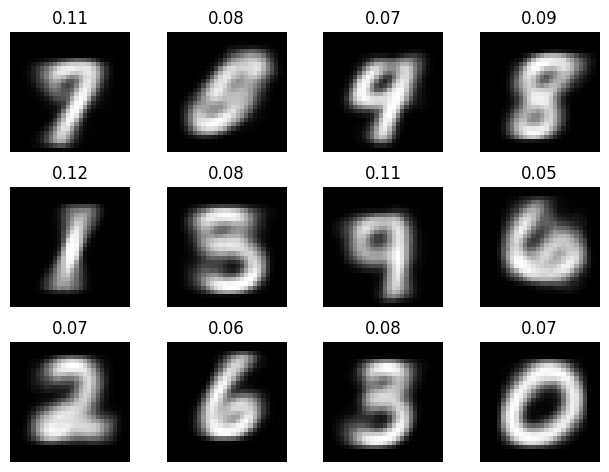

In [481]:
n_obs = 10000
rng_key = PRNGKey(0)
images,labels = load_random_data(n_obs)  # subsample the MNIST dataset

K = 12
# 28x28
dimension = 784

x = (images > 0).astype('int')  # Converting to binary
dataset_size = x.shape[0]

perm = randint(rng_key, minval=0, maxval=dataset_size, shape=((n_obs,)))
x_train = x[perm]
x_train = x_train.reshape((n_obs, dimension))

# bmm = BMM(K,dimension)
# bmm.model(bmm._parameters)
# print(bmm._model.mixture_distribution.event_shape)
# print(bmm._model.components_distribution.event_shape)
# _,cofficients_per_category_contribution_hist  = bmm.fit_expectation_maximum(x_train)

# print(cofficients_per_category_contribution_hist)
# n_row, n_col = 3,4
# bmm.plot(n_row, n_col, "bmm_em_mnist")

# n_obs = 1000
rng_key = PRNGKey(0)

observations = x_train # subsample the MNIST dataset
n_vars = len(observations[0])
K = 12
sgd = SGD(K, n_vars)
num_epochs = 500
_, coeffs, probs = sgd.fit_sgd(jnp.array(observations), batch_size=n_obs, num_epochs=num_epochs)
n_row, n_col = 3, 4
sgd.plot(coeffs, probs, n_row, n_col, "sgd_mnist")